In [197]:
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
import random



In [181]:
data1 = pd.read_csv('data/01/1_raw_data_13-12_22.03.16.txt', sep="\s+")
data2 = pd.read_csv('data/01/2_raw_data_13-13_22.03.16.txt', sep="\s+")

# test_subj = random.randint(2, 36)
# f"{test_subj:02d}""
test_data =  pd.read_csv(f"data/12/1_raw_data_11-35_28.03.16.txt", sep="\s+")

print(len(data1), len(data2))
data = data1.append(data2, ignore_index=True)
data.head()


63196 57974


,time,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class
0,1,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0
1,5,0.00001,-0.00002,-0.00001,-0.00003,0.00000,-0.00001,0.00000,-0.00001,0
2,6,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0
3,7,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0
4,8,-0.00001,0.00001,0.00002,0.00000,0.00001,-0.00002,-0.00001,0.00001,0


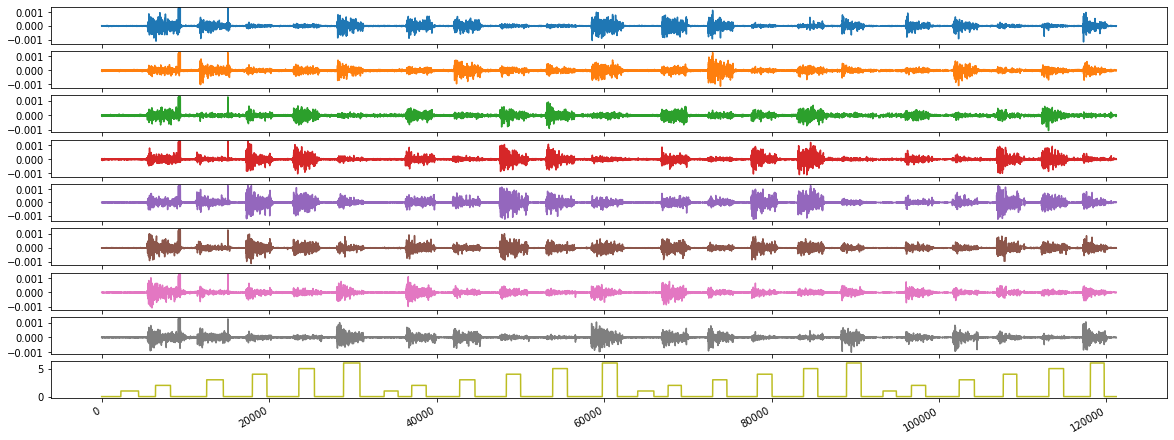

In [182]:
N = 8
ch_names = []
for i in range(8):
    ch_name = 'channel' + str(i+1)
    ch_names.append(ch_name)

participating_cols = ch_names.copy()
participating_cols.append('class')
data = data[participating_cols]

def plot_data(data):
    data.plot(subplots=True, legend=False, figsize=(20,8))
    pyplot.show()

plot_data(data)

classes = data["class"].unique()

# for c in classes:
#     class_values = data[data["class"] == c][ch_names]
#     abs_values = class_values.abs()
#     values = pd.concat([ 
#         class_values.mean().rename("Mean"), 
#         class_values.var().rename("Variance"),
#         abs_values.mean().rename("Abs Mean"),
#         abs_values.var().rename("Abs Variance")
#     ], axis=1)
#     print(f"Class {c}:\n {values} \n")    


It is reasonable to use an absolute value of the signal. 
Set of amplitudes looks unique and more or less persistent for each class (except the '0' class),   
  being the key source of information for time signals while not taking its time-nature into account. (the sign is meaningless out of the time context)  

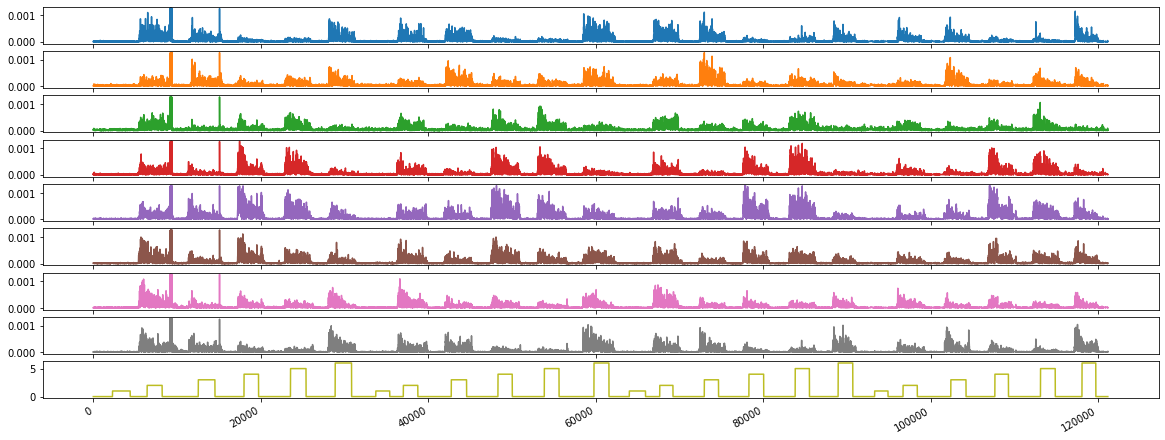

In [183]:
data = data.abs()
plot_data(data)

We can see here two clips on the first two active series within all the channels simultaneoulsly that look like artefacts or a hardware issues.
They rise maximum value that might slightly compresses a range of valid values and pollute statistics, so we discard them.

9160 0.0012699999999999999


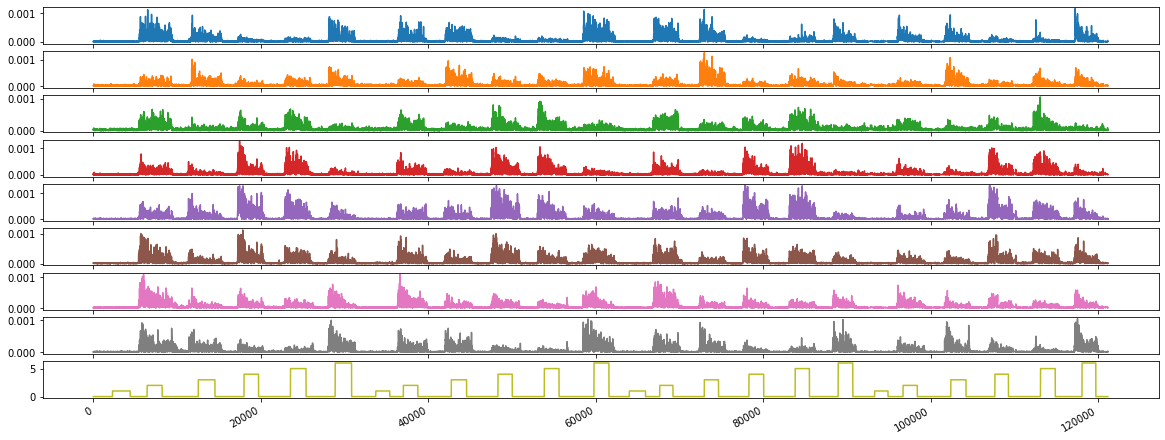

In [184]:
# using the channel3 as one with visually essential gap between clipping part and valid values
ch3 = data["channel3"]
max_val = max(ch3)
print(ch3.argmax(), max_val)

discarding_cells = ch3 < max_val*0.9
data = data[discarding_cells]
plot_data(data)


It is obvious from the visual data that class '0' is dominating, while others are more or less balanced We have ~120 000 samples so it's ok to undersample it.

In [185]:
sm = 0
for cls in classes:
    l = len(data[data["class"] == cls])
    print(f"{int(cls)}: {l}")
    if cls != 0: sm += l
mean_count = int( sm/(len(classes) - 1) )  

class0_data = data[data["class"] == 0]
class0_data = resample(class0_data, n_samples=mean_count, replace=False, random_state=42)
balanced_data = pd.concat([ data[data["class"] != 0], class0_data ], ignore_index=True)

balanced_data.head(5)

0: 78620
1: 7311
2: 6806
3: 7329
4: 6824
5: 7075
6: 7143


,channel1,channel2,channel3,channel4,channel5,channel6,channel7,channel8,class
0,0.00001,0.00000,0.00001,0.00000,0.00000,0.00001,0.00001,0.00001,1.0
1,0.00001,0.00002,0.00000,0.00001,0.00001,0.00001,0.00003,0.00002,1.0
2,0.00001,0.00002,0.00000,0.00001,0.00001,0.00001,0.00003,0.00002,1.0
3,0.00001,0.00002,0.00000,0.00001,0.00001,0.00001,0.00003,0.00002,1.0
4,0.00001,0.00002,0.00000,0.00001,0.00001,0.00001,0.00003,0.00002,1.0


In [192]:
def split_train(X, Y, test_size=0.15):
    train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=test_size)
    return (train_X, train_Y), (test_X, test_Y)

scaler
def scale_data(train, test):
    global scaler
    scaler = StandardScaler()
    train_X = scaler.fit_transform(train[0]) 
    test_X = scaler.transform(test[0])
    return (train_X, train[1]), (test_X, test[1])

def test_classifier(c, test_X, test_Y):
    pred_Y = c.predict(test_X)
    
    acc =  accuracy_score(test_Y, pred_Y)
    cm = confusion_matrix(test_Y, pred_Y)
    print( 'Confusion matrix:\n {}'.format(cm) )
    print( 'Accuracy: {:.2f}'.format(acc) )

def train_logistic_regression(train_X, train_Y):
    c = LogisticRegression(random_state = 42)
    c.fit(train_X, train_Y)
    return c

In [193]:

train, test = split_train(balanced_data[ch_names], balanced_data["class"])
train, test = scale_data(train, test)
c1 = train_logistic_regression(*train)
test_classifier(c1, *test)

Confusion matrix:
 [[ 114  566   62   69   77   75   72]
 [  28 1104    0    0    0    0    0]
 [ 108    2  633   14   53   85  150]
 [ 156   16   19  656   48   10  203]
 [ 193    5   21   35  525  217   24]
 [ 160    1   57   34  215  540   21]
 [ 200    1  125  203   42   16  481]]
Accuracy: 0.55


Not the best accuracy. Let's look at the class descriptions. The class '0' is labled as "unmarked data", which explains why it has many false positives.
We actually should discard it.

In [194]:
data = data[data["class"] != 0].reset_index()

train, test = split_train(data[ch_names], data["class"])
train, test = scale_data(train, test)

c1 = train_logistic_regression(*train)
test_classifier(c1, *test)

Confusion matrix:
 [[1063    0    0    4   10    0]
 [   2  656   29   55  123  180]
 [  37   31  654   75   22  319]
 [  30   30   43  601  227   69]
 [   8   68   60  249  641   44]
 [   6  169  243   65   29  532]]
Accuracy: 0.65


/Users/shikhu/.pyenv/versions/3.6.9/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracy increased to ~0,65! Better than coin but not the best.
We can see many false detections, especially between 4 and 5 classes, which goes for 
  "wrist extension" and "radial deviations" correspondingly. 
Also there is a big amount of cross-wrong predictions between 3 and 6 that correspond to
  "wrist flexion"  and  "ulnar deviations".

Whilest we know that our model is not perfect, these cross-disclassifications could be explaind
 from the position that subject uses quite similar set of muscles and therefore signals for gestures in each pair.

----
#### Alternatives
SVM classifier might work better on this type of data for several reasons.
It separates data based on it's geometrical properties, and we have 8d amplitude points that should concentrate in class-related clusters with specific shapes.
SVM is less sensetive to outliers, which we have some because the signal value always passes through zero line.
It also less vulnarable to overfitting which we'll check on test_data from another session.

In [198]:
def train_SVM(train_X, train_Y):
    #c = LinearSVC()
    c = SVC(decision_function_shape='ovr',random_state = 42)
    c.fit(train_X, train_Y)
    return c
    

In [199]:
c2 = train_SVM(*train)
test_classifier(c2, *test)


Confusion matrix:
 [[3537    0    0    0    0    0]
 [ 109 1233  556  213 1279   97]
 [   1  827  403  151   20 2141]
 [   1  260   60 2724  524   81]
 [  14   92 1851  871 1029   31]
 [ 107  342   35 1024   28 2096]]
Accuracy: 0.51


/Users/shikhu/.pyenv/versions/3.6.9/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy ~0.78 is much better. Let's test classifiers on data from other session

In [196]:
test_data = test_data.abs()[test_data["class"] != 0]

#train, test = scale_data((data[ch_names], data["class"]), (test_data[ch_names], test_data["class"]))
#c1 = train_logistic_regression(*train)
#c2 = train_SVM(*train)

test = (scaler.transform(test_data[ch_names]), test_data["class"])

test_classifier(c1, *test)
test_classifier(c2, *test)


Confusion matrix:
 [[3526    0   11    0    0    0]
 [  88  957  454  302 1365  321]
 [   1  412  504   60   20 2546]
 [   1  307  154 2658  448   82]
 [   5   67 1761  623 1347   85]
 [  72  133  284  923   13 2207]]
Accuracy: 0.52
Confusion matrix:
 [[3478    0   11   48    0    0]
 [  52 1319  395  644  719  358]
 [   0  495  598  137   20 2293]
 [   2  778   99 2180  482  109]
 [   5  341 1444  724 1044  330]
 [  68  481  369  916   14 1784]]
Accuracy: 0.48


Apparently, we need to fit our models on a different sessions and different subjects to extract the common features and not overfit model with subject's uniqueness.


In [189]:
# windowed_data = pd.DataFrame()
# for i in range(len(data))
#     if (i+1) in data and data[i]["class"] == data[i+1]["class"] and
#    windowed_data 

# train, test = split_train(data[ch_names], data["class"])
# train, test = scale_data(train, test)

# test_classifier(c1, *test)
# test_classifier(c2, *test)

In [ ]:
# NEXT TODO:
# Consider the time nature of the data:
# - Extract more features from time window: variance, mean, just union of all of the features
# - FFT, build spectrogram
# - Try deep learning classifier with LSTM
# Also current classifiers might be tuned:
#    SVN kernel
# ?add cross validation
